# One Dimension

This Jupyter Notebook is nearly identical to that from Figure 6. For this, we simulated in a one-dimensional area that was 100 units long. "process.py" runs sparg on a tree sequence output by SLiM. This generates the random_ancestors_1000_effective_dispersal.csv file which is used to create accuracy plots. This confirms that the patterns remain the same even under this new simulation, which should have helped to reduce the boundary effects.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import scipy.stats as st
import tskit
import sparg

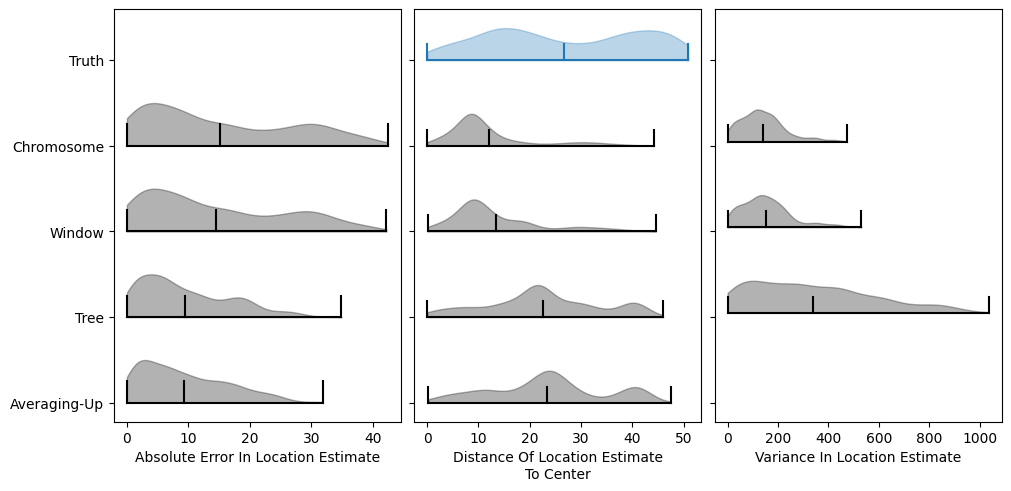

In [5]:
random_ancestors = pd.read_csv("random_ancestors_1000_effective_dispersal.csv")

gap = 0.05

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, layout="constrained", sharey=True)

vp0 = ax0.violinplot([
    random_ancestors["midpoint_abs_error"],
    random_ancestors["window_0_abs_error"],
    random_ancestors["window_100_abs_error"],
    random_ancestors["arg_abs_error"]
], showmeans=True, vert=False, side="high", widths=1)
ax0.set_xlabel("Absolute Error In Location Estimate")

for partname in ("cbars","cmins","cmaxes","cmeans"):
    vp = vp0[partname]
    vp.set_edgecolor("black")
    
for pc in vp0['bodies']:
    pc.set_color("black")

vp2 = ax1.violinplot([
    random_ancestors["midpoint_dist_to_center"],
    random_ancestors["window_0_dist_to_center"],
    random_ancestors["window_100_dist_to_center"],
    random_ancestors["arg_dist_to_center"]
], showmeans=True, vert=False, side="high", widths=0.75)
vp2_true = ax1.violinplot([
    random_ancestors["true_dist_to_center"]
], showmeans=True, vert=False, side="high", widths=0.75, positions=[5])
ax1.set_xlabel("Distance Of Location Estimate\nTo Center")

for partname in ("cbars","cmins","cmaxes","cmeans"):
    vp2[partname].set_edgecolor("black")
    vp2_true[partname].set_edgecolor("#1f77b4")

for pc in vp2["bodies"]:
    pc.set_color("black")
for pc in vp2_true["bodies"]:
    pc.set_color("#1f77b4")

vp1_x = ax2.violinplot([
    random_ancestors["window_0_variance_in_estimated_location_0"],
    random_ancestors["window_100_variance_in_estimated_location_0"],
    random_ancestors["arg_variance_in_estimated_location_0"],
], showmeans=True, vert=False, side="high", widths=0.75, positions=[2+gap,3+gap,4+gap])
ax2.set_xlabel("Variance In Location Estimate")

for partname in ("cbars","cmins","cmaxes","cmeans"):
    vp1_x[partname].set_edgecolor("black")

for pc in vp1_x["bodies"]:
    pc.set_color("black")

plt.yticks([5,4,3,2,1], ["Truth", "Chromosome", "Window", "Tree", "Averaging-Up"])
fig.set_figwidth(10)
plt.savefig("OneDimension.svg")
plt.show()

In [4]:
# set seed
#np.random.seed(10)
np.random.seed(20)


# load and filter the tree sequence
cutoff = 2000
ts = tskit.load("../../../simulations/UniformStartOneDim/outputs/original/S025_I1_R2_W100_D1/rep0_S025_I1_R2_W100_D1.trees")

samples = list(np.random.choice(ts.samples(), 500, replace=False))
ts_sim, map_sim = ts.simplify(samples=samples, map_nodes=True, keep_input_roots=False, keep_unary=True, update_sample_flags=False)
ts_final, maps_final = sparg.simplify_with_recombination(ts=ts_sim, flag_recomb=True)
ts_chopped = sparg.chop_arg(ts=ts_final, time=cutoff)

In [6]:
ts_breaks = ts_chopped.breakpoints(as_array=True)

In [24]:
def locate_nodes(nodes, SpARG):
    """Calculate the location of the list of nodes

    Parameters
    ----------
    nodes : list
        List of nodes for which the locations will be calculated
    SpARG : SpatialARG
    	An instance of the SpatialARG class defined below. 

    Returns
    -------
    node_locations : dict
        The keys are the nodes. The values are the geographic location of the nodes in n dimensions
    variance_in_node_locations : dict
        The keys are the nodes. The values are the variance in the geographic location of the nodes in n dimensions
    """

    sigma = SpARG.dispersal_rate_matrix
    paths = SpARG.paths
    inverted_cov_mat = SpARG.inverted_paths_shared_time_matrix
    sample_locs_to_root_locs = SpARG.path_dispersal_distances
    root_locations = SpARG.root_locations
    node_shared_times = SpARG.node_paths_shared_times
    node_paths = SpARG.node_paths
    ts = SpARG.ts
    
    location_of_nodes = {} 
    variance_in_node_locations = {} 
    
    for i,node in enumerate(nodes): 
        node_specific_sharing = node_shared_times[node,:].copy()
        matmul_prod = np.matmul(node_specific_sharing, inverted_cov_mat)
        root_location = root_locations[node_paths[node][-1]]
        node_location = root_location + np.matmul(matmul_prod, sample_locs_to_root_locs)
        location_of_nodes[node] = node_location
        
        base_variance = np.matmul(matmul_prod, np.transpose(node_specific_sharing))
        ones = np.ones(inverted_cov_mat.shape[0])
        correction_denominator = np.matmul(np.matmul(np.transpose(ones),inverted_cov_mat),ones)
        correction_numerator = (1-np.matmul(np.matmul(np.transpose(node_specific_sharing),inverted_cov_mat),ones))**2
        corrected_variance_scaling_factor = (ts.max_root_time-ts.node(node).time)-base_variance+(correction_numerator/correction_denominator)
        total_variance_node = sigma*corrected_variance_scaling_factor
        variance_in_node_locations[node] = total_variance_node
    return location_of_nodes, variance_in_node_locations

def average_dispersal_treewise(ts, locations_of_nodes):
    branch_lengths = ts.tables.nodes.time[ts.tables.edges.parent] - ts.tables.nodes.time[ts.tables.edges.child]
    child_locations = np.array(list( map(locations_of_nodes.get, ts.tables.edges.child) ))
    parent_locations = np.array(list( map(locations_of_nodes.get, ts.tables.edges.parent) ))
    branch_distances = parent_locations - child_locations 
    ts_trees = ts.aslist()
    dispersal_rate = []
    average_dispersal_rate = []
    for ts_tree in ts_trees:     
        edge_ind = ts_tree.edge_array[ts_tree.edge_array>-1]
        tree_branch_lengths = branch_lengths[edge_ind]
        tree_branch_distances = branch_distances[edge_ind]
        tree_dispersal_rate = [ np.matmul( np.transpose([tree_branch_distances[i]]),[tree_branch_distances[i]] )/tree_branch_lengths[i] for i in range(len(tree_branch_distances)) ]
        tree_dispersal_rate = np.sum(np.array(tree_dispersal_rate), axis=0)/ts.num_samples   
        dispersal_rate += [tree_dispersal_rate]
        average_dispersal_rate += [ np.average(np.array(dispersal_rate), axis=0) ]
    return dispersal_rate, average_dispersal_rate 

In [65]:
i_list = []
bp_list = []
arg_disp = []
tree_disp = []

unique_edges = np.unique(np.column_stack((ts_chopped.edges_child, ts_chopped.edges_parent)), axis=0)
child_individuals = ts_chopped.tables.nodes.individual[np.array(unique_edges[:,0])]
parent_individuals = ts_chopped.tables.nodes.individual[np.array(unique_edges[:,1])]

unique_edges = unique_edges[np.where(parent_individuals > 0)[0],:]
child_individuals = child_individuals[np.where(parent_individuals > 0)[0]]
parent_individuals = parent_individuals[np.where(parent_individuals > 0)[0]]

child_locations = ts_chopped.tables.individuals[child_individuals].location.reshape(len(unique_edges[:,0]),3)
parent_locations = ts_chopped.tables.individuals[parent_individuals].location.reshape(len(unique_edges[:,0]),3)

child_times = ts_chopped.tables.nodes.time[unique_edges[:,0]]
parent_times = ts_chopped.tables.nodes.time[unique_edges[:,1]]

disp_x = np.sum((child_locations[:,0]-parent_locations[:,0])**2/([parent_times-child_times]),axis=1)/len(unique_edges)

for (bp_i,bp) in enumerate(ts_breaks[:-1]):
    if bp_i > 0:
        ts_short = ts_chopped.keep_intervals(intervals=[(0,bp)], simplify=False).trim()
        ts_short_sim, maps_short_sim = sparg.simplify_with_recombination(ts=ts_short)
        ts_short_attached = sparg.chop_arg(ts=ts_short_sim, time = ts_short.max_time)

        ts_tree = ts_short_attached.keep_intervals(intervals=[(ts_breaks[bp_i-1],bp)], simplify=False).trim() 
        ts_tree = sparg.chop_arg(ts=ts_tree,time= ts_tree.max_time)
        
        PartialARG = sparg.SpatialARG(ts=ts_short_attached, dimensions=1, verbose=False)
        Tree = sparg.SpatialARG(ts=ts_tree, dimensions=1, verbose=False)
        
        i_list.append(bp_i)
        bp_list.append(bp)
        arg_disp.append(PartialARG.dispersal_rate_matrix[0][0])
        tree_disp.append(Tree.dispersal_rate_matrix[0][0])

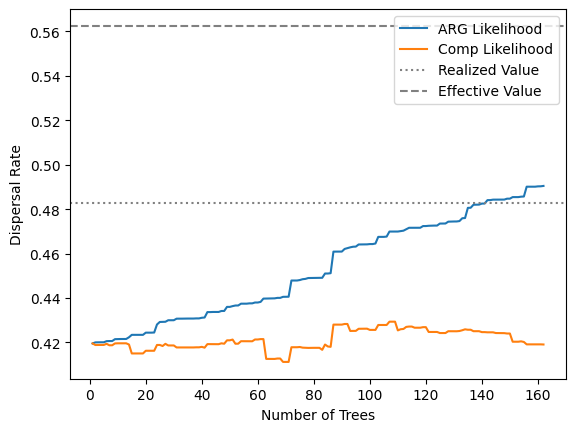

In [66]:
plt.plot(i_list, arg_disp, label="ARG Likelihood")
plt.plot(i_list, tree_disp, label="Comp Likelihood")
plt.axhline(disp_x, c="grey", linestyle="dotted", label="Realized Value")
plt.axhline(0.25*0.25+0.5, c="grey", linestyle="dashed", label="Effective Value")
plt.xlabel("Number of Trees")
plt.ylabel("Dispersal Rate")
plt.legend()
plt.savefig("OneDimension_DispersalRate.png")
plt.show()